# CAPSTONE PROJECT - CIFAR10

In [1]:
## Import libraries
import numpy as np
import pandas as pd
import itertools


# Import visualization libraries
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from skimage.filters import gaussian
import visualkeras


from sklearn.metrics import confusion_matrix

# import tensorflow
import tensorflow as tf

# import keras
from keras.models import Sequential
from keras.layers import Dense, Flatten, BatchNormalization, Activation
from keras.layers import Conv2D, MaxPool2D, Dropout
from keras.layers import Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from keras.utils import np_utils
from keras.constraints import maxnorm

from keras.preprocessing.image import ImageDataGenerator

# import CIFAR 10 dataset
from keras.datasets import cifar10

In [2]:
# Loading data & splitting to train and test sets
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.cifar10.load_data()

In [3]:
# Checking the shape of the data - 50000 training images, 10000 test images
# All images 32 x 32 pixel and 3 channels(a.k.a RGB - colored)
X_train.shape, X_test.shape

((50000, 32, 32, 3), (10000, 32, 32, 3))

## Useful functions to be used

In [4]:
# Useful function to create confusion matrix
def print_cm(cm):
    d_size = max(len('%d' % cm.max()), len('%d' % cm.shape[1]))
    if min(cm.shape) > 10: # make sparse
        print('Sparse Matrix (*=diagonal)')
        fmt_c = ', c%%0%dd%%s= %%%dd' % (d_size, d_size)
        for i in range(cm.shape[0]):
            s = fmt_r % i
            for j in range(cm.shape[1]):
                if cm[i, j] > 0:
                    s += fmt_c % (j, '*' if i == j else ' ', cm[i, j])
            print(s)
    else: # make dense
        c = '%%%dd ' % d_size
        s = '%s| ' % (' ' * d_size)
        s += ''.join([c % i for i in range(len(cm[0]))])
        print(s)
        print('-' * len(s))
        for i, r in enumerate(cm):
            s = '%%%dd| ' % d_size
            s = s % i
            s += c * len(r)
            print(s % tuple(r))

In [5]:
# Useful function to create confusion matrix as heatmap

labels = ['Plane', 'Car', 'Bird', 'Cat', 'Deer','Dog','Frog','Horse','Ship','Truck']

def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(12, 12))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

In [6]:
# Useful function to be able to check 1 prediction for models
def check_one(data, label, id = None, actual = None, compare = False):
    # check one
    if id is None:
        id = np.random.randint(data.shape[0])
    im = gaussian(data[id], channel_axis = True)
    plt.figure(figsize = (3, 3))
    plt.imshow(im)
    
    l_id = label[id]
    if (compare) and (actual is not None) and (l_id != np.argmax(actual[id])):
        a_id = np.argmax(actual[id])
        plt.title('Class %d (%s) [\u2260 %d-%s]' % (l_id, labels[l_id], a_id, labels[a_id]))
    else:
        plt.title('Class %d (%s)' % (l_id, labels[l_id]))
    plt.xticks([])
    plt.yticks([])
    plt.show()

In [7]:
# Useful function to be able to check 10 predictions for models
def check_ten(data, label, actual = None, compare = False):
    # check ten
    fig, ax = plt.subplots(2, 5, figsize = (11, 5))
    fig.subplots_adjust(left = 0.02, right = 0.98, top = 0.8, wspace = 0.2, hspace = 0.2)
    fig.suptitle('Check Data', fontsize = 12, fontweight = 'bold')

    plt.rcParams.update({'font.size': 10})

    ids = np.random.randint(data.shape[0], size = 10)
    r = 0
    c = 0
    for id in ids:
        im = data[id]
        #im = gaussian(data[id], channel_axis = True)

        # original image
        ax[r, c].imshow(im)
        l_id = label[id]
        if (compare) and (actual is not None) and (l_id != np.argmax(actual[id])):
            a_id = np.argmax(actual[id])
            ax[r, c].set_title('Class %d (%s) [\u2260 %d-%s]' % (l_id, labels[l_id], a_id, labels[a_id]))
        else:
            ax[r, c].set_title('Class %d (%s)' % (l_id, labels[l_id]))
        ax[r, c].set_xticks([])
        ax[r, c].set_yticks([])
        c += 1
        if c > 4:
            r += 1
            c = 0

    plt.show()

## EDA's

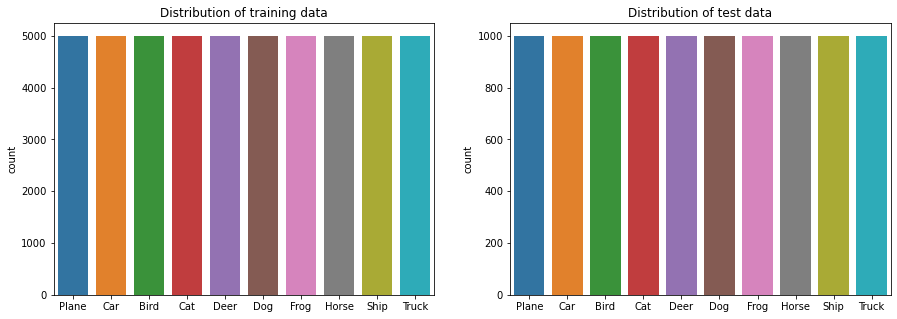

In [8]:
# Checking distibution of classes in train and test datasets

fig, axs = plt.subplots(1, 2, figsize = (15, 5))

g = sns.countplot(x = y_train.ravel(), ax = axs[0])
g.set_title('Distribution of training data')
g.set_label('Classes')
g.set_xticklabels(['Plane','Car','Bird','Cat','Deer','Dog','Frog','Horse','Ship','Truck'])

g1 = sns.countplot(x = y_test.ravel(), ax = axs[1])
g1.set_title('Distribution of test data')
g1.set_label('Classes')
g1.set_xticklabels(['Plane','Car','Bird','Cat','Deer','Dog','Frog','Horse','Ship','Truck'])

plt.show()

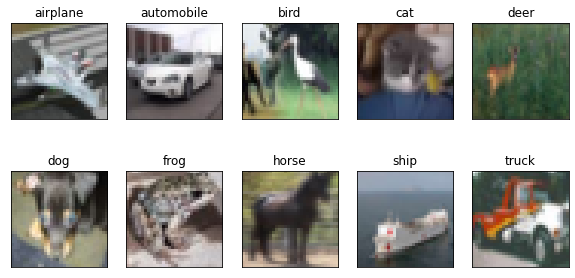

In [9]:
# Plotting some random 10 images

class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']

num_classes = 10

fig = plt.figure(figsize=(10,5))
for i in range(num_classes):
    ax = fig.add_subplot(2, 5, 1 + i, xticks=[], yticks=[])
    idx = np.where(y_train[:]==i)[0]
    features_idx = X_train[idx,::]
    img_num = np.random.randint(features_idx.shape[0])
    im = (features_idx[img_num,::])
    ax.set_title(class_names[i])
    plt.imshow(im)
plt.show()

## Data Preprocessing

In [10]:
# Normalize the numbers
X_train = X_train.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0

In [11]:
# One hot encode outputs as we have 10 classes
y_train = np_utils.to_categorical(y_train)
y_test = np_utils.to_categorical(y_test)
class_num = y_test.shape[1]

In [12]:
# Image augmentation to be able create noise
train_datagen = ImageDataGenerator(
        rotation_range=45,     #Random rotation between 0 and 45
        width_shift_range=0.2,   #% shift
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='reflect', cval=125)

train_datagen.fit(X_train)

train_generator = train_datagen.flow(
    X_train,
    y_train,
    batch_size = 32)

## RESNET50

In [13]:
# Instentiate RESNET50  
resnet_model = Sequential()

pretrained_resnet_model= tf.keras.applications.ResNet50(include_top=False,
                   input_shape=(32,32,3),
                   pooling='avg',classes=10,
                   weights='imagenet')
for layer in pretrained_resnet_model.layers:
        layer.trainable=False

resnet_model.add(pretrained_resnet_model)

In [14]:
# Flatten and add Dense Layers to the model
resnet_model.add(Flatten())
resnet_model.add(Dense(4096,activation="relu"))
resnet_model.add(Dense(4096,activation="relu"))
resnet_model.add(Dropout(0.2))
resnet_model.add(BatchNormalization())

resnet_model.add(Dense(512, activation='relu'))
resnet_model.add(Dense(256, activation='relu'))
resnet_model.add(Dense(128, activation='relu'))
resnet_model.add(Dense(64, activation='relu'))
resnet_model.add(Dense(32, activation='relu'))

# Output layer with 10 classes
resnet_model.add(Dense(10, activation='softmax'))

In [15]:
# Resnet model summary
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 2048)              23587712  
_________________________________________________________________
flatten (Flatten)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 4096)              8392704   
_________________________________________________________________
dense_1 (Dense)              (None, 4096)              16781312  
_________________________________________________________________
dropout (Dropout)            (None, 4096)              0         
_________________________________________________________________
batch_normalization (BatchNo (None, 4096)              16384     
_________________________________________________________________
dense_2 (Dense)              (None, 512)               2

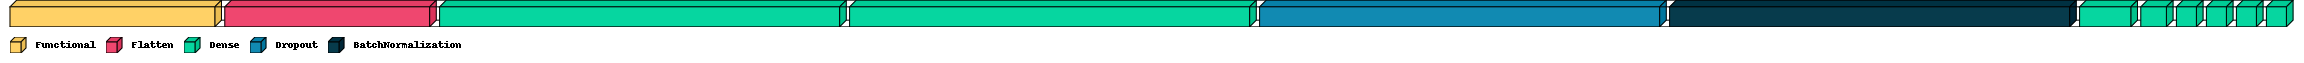

In [16]:
# Visualizing our model 
visualkeras.layered_view(resnet_model, scale_xy=10, legend=True)

In [17]:
%%time
# Compile the model
resnet_model.compile(optimizer=Adam(learning_rate=0.001),loss='categorical_crossentropy',metrics=['accuracy'])

# Train the model 
resnet_history = resnet_model.fit(train_generator, validation_data=(X_test, y_test), epochs=200, batch_size = 100, steps_per_epoch = 1000)

Epoch 1/200
1000/1000 [==============================] - 162s 158ms/step - loss: 2.2443 - accuracy: 0.1446 - val_loss: 2.4229 - val_accuracy: 0.1362
Epoch 2/200
1000/1000 [==============================] - 227s 227ms/step - loss: 2.1645 - accuracy: 0.1815 - val_loss: 4.1476 - val_accuracy: 0.1041
Epoch 3/200
1000/1000 [==============================] - 206s 206ms/step - loss: 2.1171 - accuracy: 0.2013 - val_loss: 2.1379 - val_accuracy: 0.1760
Epoch 4/200
1000/1000 [==============================] - 198s 198ms/step - loss: 2.0812 - accuracy: 0.2148 - val_loss: 2.3872 - val_accuracy: 0.1408
Epoch 5/200
1000/1000 [==============================] - 174s 174ms/step - loss: 2.0568 - accuracy: 0.2229 - val_loss: 1.9860 - val_accuracy: 0.2507
Epoch 6/200
1000/1000 [==============================] - 177s 177ms/step - loss: 2.0336 - accuracy: 0.2366 - val_loss: 2.0042 - val_accuracy: 0.2376
Epoch 7/200
1000/1000 [==============================] - 191s 191ms/step - loss: 2.0334 - accuracy: 0.2385

In [18]:
# Evaluating the model with test set
resnet_score = resnet_model.evaluate(X_test, y_test, batch_size = 10)
print('\nTest loss: %.6f, Test accuracy: %.6f' % tuple(resnet_score))

1000/1000 [==============================] - 54s 53ms/step - loss: 2.3026 - accuracy: 0.1000

Test loss: 2.302614, Test accuracy: 0.100000


In [19]:
# Saving the model to be able to use later
import h5py
resnet_model.save('resnet_model')
print('Saved model to disk')

# Save model
resnet_model_json = resnet_model.to_json()
with open('resnet_model.json', 'w') as json_file:
     json_file.write(resnet_model_json)
# Save weights
resnet_model.save_weights('resnet_model.h5')
print("Saved model to disk")

INFO:tensorflow:Assets written to: resnet_model\assets


C:\Users\isabe\anaconda3_1\envs\iod_deep_learning\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Saved model to disk
Saved model to disk


In [20]:
%%time
# RESNET50 predictions on test data
resnet_predictions = np.argmax(resnet_model.predict(X_test),axis=1)

CPU times: total: 3min 36s
Wall time: 32 s


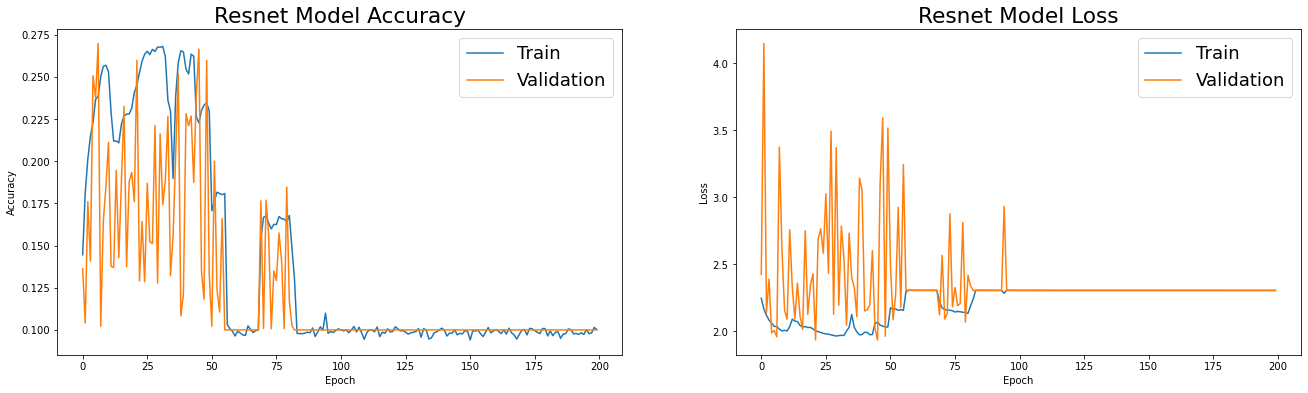

In [21]:
# Visualize accuracy and loss for RESNET50
fig, ax = plt.subplots(1, 2, figsize = (18, 6))
fig.subplots_adjust(left = 0.02, right = 0.98, wspace = 0.2)

plt.rcParams.update({'font.size': 18})

# Plot training & validation accuracy values
ax[0].plot(resnet_history.history['accuracy'])
ax[0].plot(resnet_history.history['val_accuracy'])
ax[0].set_title('Resnet Model Accuracy')
ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].legend(['Train', 'Validation'])

# Plot training & validation loss values
ax[1].plot(resnet_history.history['loss'])
ax[1].plot(resnet_history.history['val_loss'])
ax[1].set_title('Resnet Model Loss')
ax[1].set_ylabel('Loss')
ax[1].set_xlabel('Epoch')
ax[1].legend(['Train', 'Validation'])

plt.show()

In [22]:
# Confusion matrix for RESNET50
y_test_resnet_target = np.array([x.argmax() for x in y_test])
resnet_cm = confusion_matrix(y_test_resnet_target, resnet_predictions)
print_cm(resnet_cm)

    |    0    1    2    3    4    5    6    7    8    9 
--------------------------------------------------------
   0|    0    0    0    0    0    0    0 1000    0    0 
   1|    0    0    0    0    0    0    0 1000    0    0 
   2|    0    0    0    0    0    0    0 1000    0    0 
   3|    0    0    0    0    0    0    0 1000    0    0 
   4|    0    0    0    0    0    0    0 1000    0    0 
   5|    0    0    0    0    0    0    0 1000    0    0 
   6|    0    0    0    0    0    0    0 1000    0    0 
   7|    0    0    0    0    0    0    0 1000    0    0 
   8|    0    0    0    0    0    0    0 1000    0    0 
   9|    0    0    0    0    0    0    0 1000    0    0 


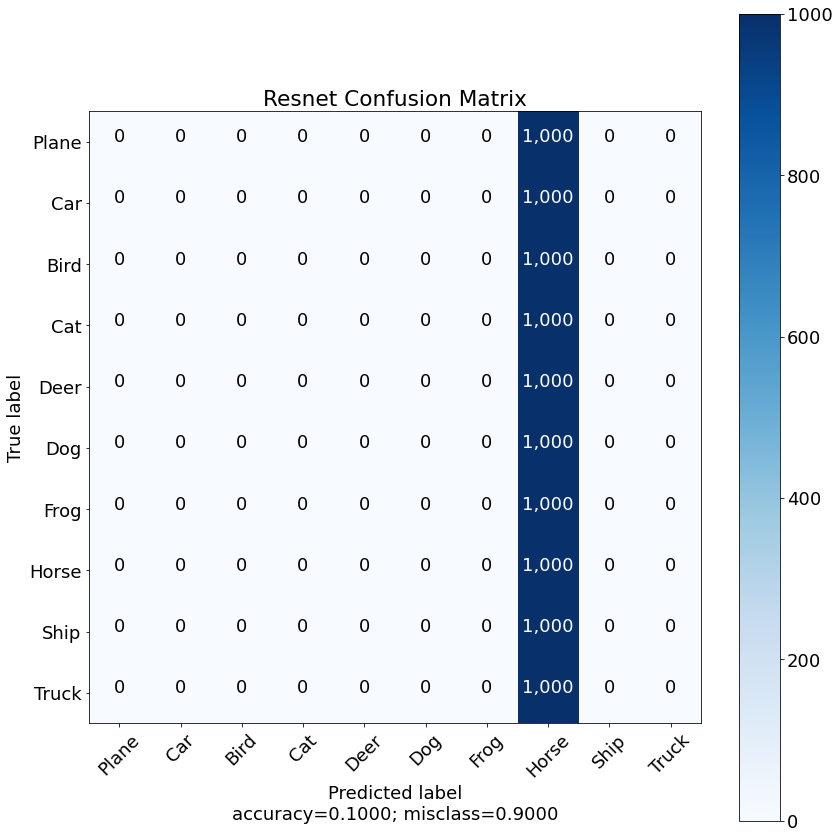

In [23]:
# Heatmap for RESNET50
plot_confusion_matrix(resnet_cm,
                          target_names = labels,
                          title='Resnet Confusion Matrix',
                          cmap="Blues",
                          normalize=False)

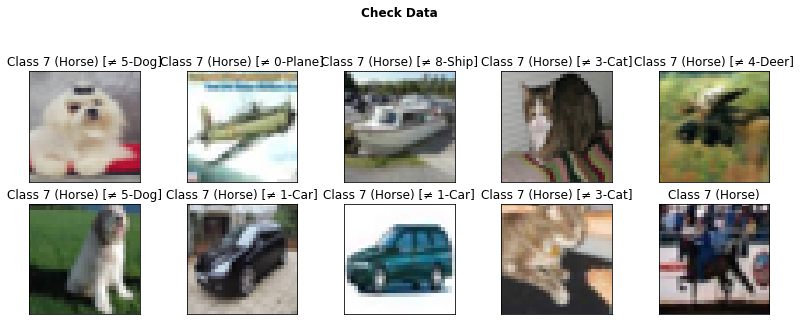

In [24]:
# Check 10 test data predictions on RESNET50 model
check_ten(X_test, resnet_predictions, y_test, compare = True)

## VGG16

In [25]:
# Instentiate VGG16 model
VGG16 = Sequential()

pretrained_VGG16_model= tf.keras.applications.VGG16(include_top=False,
                   input_shape=(32,32,3),
                   pooling='avg',classes=10,
                   weights='imagenet')
for layer in pretrained_VGG16_model.layers:
        layer.trainable=False

VGG16.add(pretrained_VGG16_model)

In [26]:
# Flatten and add Dense Layers to the model
VGG16.add(Flatten())
VGG16.add(Dense(4096,activation="relu"))
VGG16.add(Dense(4096,activation="relu"))
VGG16.add(Dropout(0.2))
VGG16.add(BatchNormalization())

VGG16.add(Dense(512, activation='relu'))
VGG16.add(Dense(256, activation='relu'))
VGG16.add(Dense(128, activation='relu'))
VGG16.add(Dense(64, activation='relu'))
VGG16.add(Dense(32, activation='relu'))

# Output layer with 10 classes
VGG16.add(Dense(10, activation='softmax'))

In [27]:
# VGG16 model summary
VGG16.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 512)               14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 512)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 4096)              2101248   
_________________________________________________________________
dense_9 (Dense)              (None, 4096)              16781312  
_________________________________________________________________
dropout_1 (Dropout)          (None, 4096)              0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 4096)              16384     
_________________________________________________________________
dense_10 (Dense)             (None, 512)              

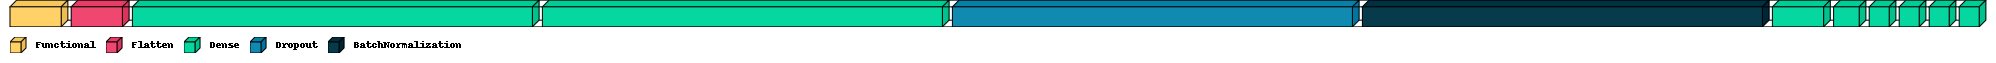

In [28]:
# Visualizing our model 
visualkeras.layered_view(VGG16, scale_xy=10, legend=True)

In [29]:
%%time
# Compile the model
VGG16.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
VGG16_history = VGG16.fit(train_generator, validation_data=(X_test, y_test), epochs=200, batch_size = 100, steps_per_epoch = 1000)

Epoch 1/200
1000/1000 [==============================] - 197s 195ms/step - loss: 1.7914 - accuracy: 0.3560 - val_loss: 1.6954 - val_accuracy: 0.4085
Epoch 2/200
1000/1000 [==============================] - 190s 190ms/step - loss: 1.6515 - accuracy: 0.4185 - val_loss: 1.5582 - val_accuracy: 0.4671
Epoch 3/200
1000/1000 [==============================] - 198s 198ms/step - loss: 1.6037 - accuracy: 0.4427 - val_loss: 1.4805 - val_accuracy: 0.4707
Epoch 4/200
1000/1000 [==============================] - 203s 203ms/step - loss: 1.5714 - accuracy: 0.4489 - val_loss: 1.4219 - val_accuracy: 0.5055
Epoch 5/200
1000/1000 [==============================] - 188s 188ms/step - loss: 1.5600 - accuracy: 0.4544 - val_loss: 1.3952 - val_accuracy: 0.5090
Epoch 6/200
1000/1000 [==============================] - 195s 195ms/step - loss: 1.5389 - accuracy: 0.4661 - val_loss: 1.3917 - val_accuracy: 0.5090
Epoch 7/200
1000/1000 [==============================] - 201s 201ms/step - loss: 1.5261 - accuracy: 0.4682

In [30]:
# Evaluating the model with test data
VGG16_score = VGG16.evaluate(X_test, y_test, batch_size = 10)
print('\nTest loss: %.6f, Test accuracy: %.6f' % tuple(VGG16_score))

1000/1000 [==============================] - 72s 71ms/step - loss: 1.2071 - accuracy: 0.6101

Test loss: 1.207090, Test accuracy: 0.610100


In [31]:
# Saving the model to be able to use later
import h5py
VGG16.save('VGG16_model')
print('Saved model to disk')

# Save model
VGG16_json = VGG16.to_json()
with open('VGG16.json', 'w') as json_file:
     json_file.write(VGG16_json)
# Save weights
VGG16.save_weights('VGG16.h5')
print("Saved model to disk")

INFO:tensorflow:Assets written to: VGG16_model\assets
Saved model to disk
Saved model to disk


In [32]:
%%time
# VGG16 predictions on test data
VGG16_predictions = np.argmax(VGG16.predict(X_test),axis=1)

CPU times: total: 3min 39s
Wall time: 32 s


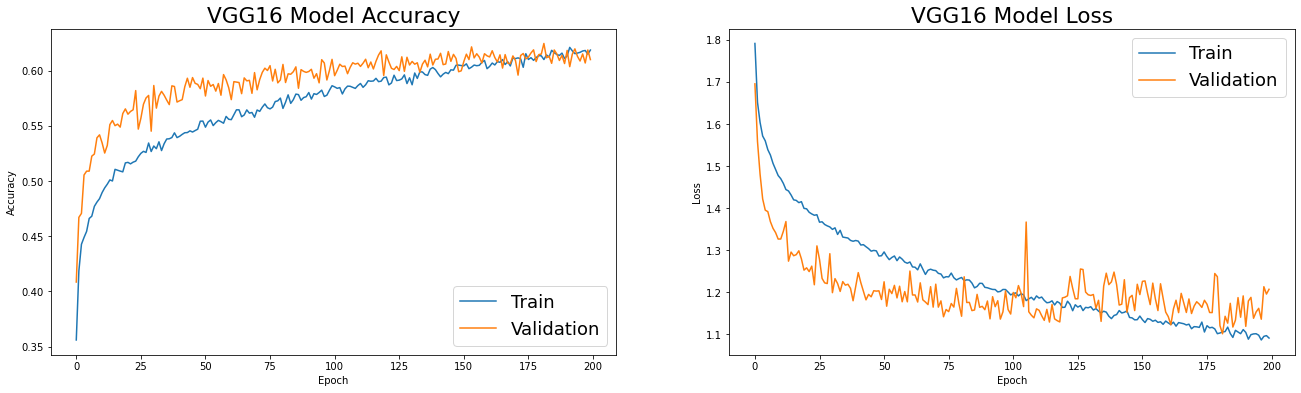

In [33]:
# Visualize accuracy and loss for VGG16
fig, ax = plt.subplots(1, 2, figsize = (18, 6))
fig.subplots_adjust(left = 0.02, right = 0.98, wspace = 0.2)

plt.rcParams.update({'font.size': 18})

# Plot training & validation accuracy values
ax[0].plot(VGG16_history.history['accuracy'])
ax[0].plot(VGG16_history.history['val_accuracy'])
ax[0].set_title('VGG16 Model Accuracy')
ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].legend(['Train', 'Validation'])

# Plot training & validation loss values
ax[1].plot(VGG16_history.history['loss'])
ax[1].plot(VGG16_history.history['val_loss'])
ax[1].set_title('VGG16 Model Loss')
ax[1].set_ylabel('Loss')
ax[1].set_xlabel('Epoch')
ax[1].legend(['Train', 'Validation'])

plt.show()

In [34]:
# Confusion matrix for VGG16
y_test_VGG16_target = np.array([x.argmax() for x in y_test])
VGG16_cm = confusion_matrix(y_test_VGG16_target, VGG16_predictions)
print_cm(VGG16_cm)

   |   0   1   2   3   4   5   6   7   8   9 
---------------------------------------------
  0| 682  27  62  13  19   3  11  22  95  66 
  1|  27 669  25  23   3  17  40  16  32 148 
  2|  44  18 559  45  72  64 131  40   7  20 
  3|  26  38  86 364  34 150 189  47  19  47 
  4|  16  15 102  37 449  35 225  71  19  31 
  5|  20  19  55 122  43 525 106  71   9  30 
  6|   4  17  63  27  31  42 804   1   4   7 
  7|  22  19  41  32  68  48  39 663  11  57 
  8|  69  62  33  17  11   2  16   2 738  50 
  9|  29 133  19  36   3  22  50  12  48 648 


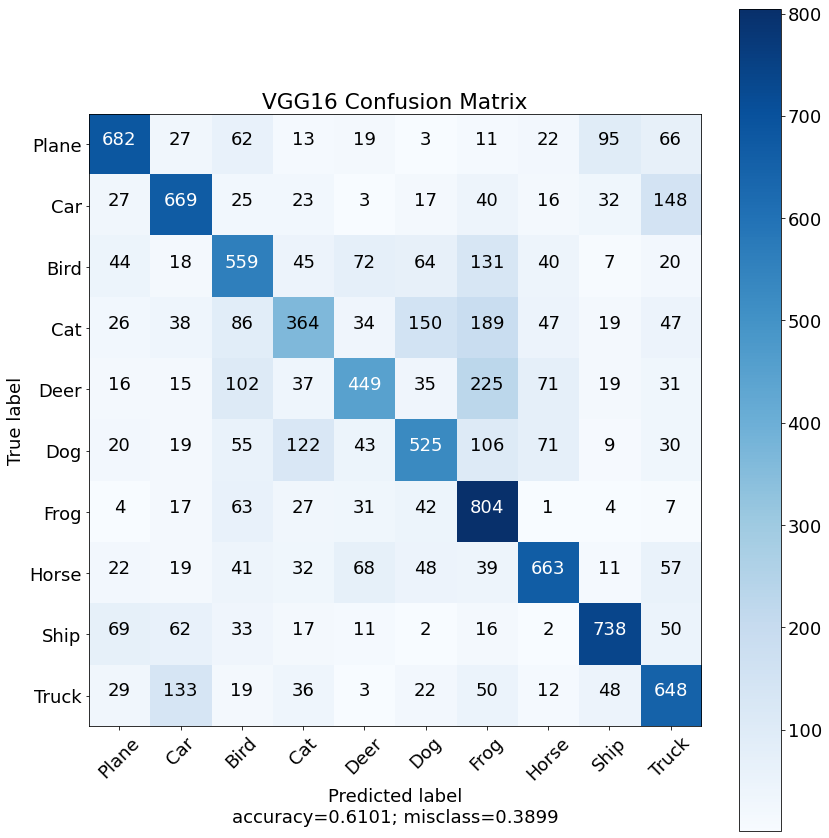

In [35]:
# Heatmap for VGG16
plot_confusion_matrix(VGG16_cm,
                          target_names = labels,
                          title='VGG16 Confusion Matrix',
                          cmap="Blues",
                          normalize=False)

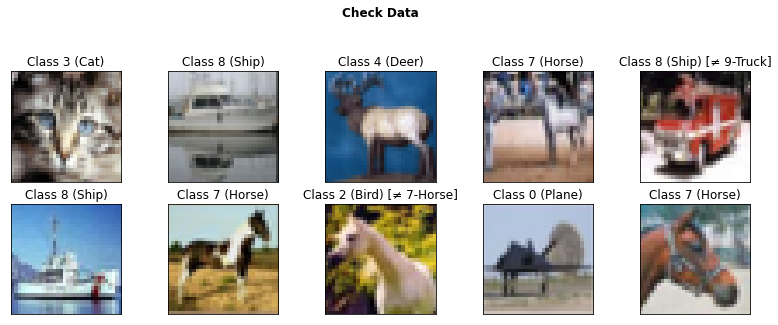

In [36]:
# Check 10 test data predictions on VGG16 model
check_ten(X_test, VGG16_predictions, y_test, compare = True)

## DENSENET121

In [37]:
# Instentiate DENSENET121
densenet_model = Sequential()

pretrained_DENSENET121_model= tf.keras.applications.DenseNet121(include_top=False,
                   input_shape=(32,32,3),
                   pooling='avg',classes=10,
                   weights='imagenet')
for layer in pretrained_DENSENET121_model.layers:
        layer.trainable=False

densenet_model.add(pretrained_DENSENET121_model)

In [38]:
# Flatten and add Dense Layers to the model
densenet_model.add(Flatten())
densenet_model.add(Dense(4096,activation="relu"))
densenet_model.add(Dense(4096,activation="relu"))
densenet_model.add(Dropout(0.2))
densenet_model.add(BatchNormalization())

densenet_model.add(Dense(512, activation='relu'))
densenet_model.add(Dense(256, activation='relu'))
densenet_model.add(Dense(128, activation='relu'))
densenet_model.add(Dense(64, activation='relu'))
densenet_model.add(Dense(32, activation='relu'))

# Output layer with 10 classes
densenet_model.add(Dense(10, activation='softmax'))

In [39]:
# DENSENET121 model summary
densenet_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet121 (Functional)     (None, 1024)              7037504   
_________________________________________________________________
flatten_2 (Flatten)          (None, 1024)              0         
_________________________________________________________________
dense_16 (Dense)             (None, 4096)              4198400   
_________________________________________________________________
dense_17 (Dense)             (None, 4096)              16781312  
_________________________________________________________________
dropout_2 (Dropout)          (None, 4096)              0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 4096)              16384     
_________________________________________________________________
dense_18 (Dense)             (None, 512)              

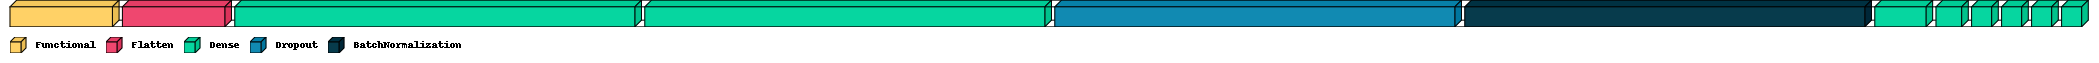

In [40]:
# Visualizing our model 
visualkeras.layered_view(densenet_model, scale_xy=10, legend=True)

In [41]:
%%time
# Compile the model
densenet_model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
densenet_model_history = densenet_model.fit(train_generator, validation_data=(X_test, y_test), epochs=200, batch_size = 100, steps_per_epoch = 1000)

Epoch 1/200
1000/1000 [==============================] - 137s 131ms/step - loss: 1.7192 - accuracy: 0.3804 - val_loss: 1.4687 - val_accuracy: 0.4798
Epoch 2/200
1000/1000 [==============================] - 124s 124ms/step - loss: 1.5342 - accuracy: 0.4620 - val_loss: 1.3015 - val_accuracy: 0.5526
Epoch 3/200
1000/1000 [==============================] - 125s 124ms/step - loss: 1.4872 - accuracy: 0.4827 - val_loss: 1.3306 - val_accuracy: 0.5378
Epoch 4/200
1000/1000 [==============================] - 126s 126ms/step - loss: 1.4468 - accuracy: 0.4962 - val_loss: 1.2314 - val_accuracy: 0.5777
Epoch 5/200
1000/1000 [==============================] - 123s 123ms/step - loss: 1.4279 - accuracy: 0.5048 - val_loss: 1.2506 - val_accuracy: 0.5718
Epoch 6/200
1000/1000 [==============================] - 122s 122ms/step - loss: 1.3999 - accuracy: 0.5155 - val_loss: 1.2528 - val_accuracy: 0.5598
Epoch 7/200
1000/1000 [==============================] - 122s 122ms/step - loss: 1.3788 - accuracy: 0.5213

In [42]:
# Evaluating the model on test data
densenet_score = densenet_model.evaluate(X_test, y_test, batch_size = 10)
print('\nTest loss: %.6f, Test accuracy: %.6f' % tuple(densenet_score))

1000/1000 [==============================] - 41s 38ms/step - loss: 3.0897 - accuracy: 0.6739

Test loss: 3.089717, Test accuracy: 0.673900


In [43]:
# Saving the model to be able to use later 
import h5py
densenet_model.save('densenet121_model')
print('Saved model to disk')

# Save model
densenet121_model_json = densenet_model.to_json()
with open('densenet121_model.json', 'w') as json_file:
     json_file.write(densenet121_model_json)
# Save weights
densenet_model.save_weights('densenet121_model.h5')
print("Saved model to disk")

INFO:tensorflow:Assets written to: densenet121_model\assets
Saved model to disk
Saved model to disk


In [44]:
%%time
# DENSENET121 predictions on test data
densenet_predictions = np.argmax(densenet_model.predict(X_test),axis=1)

CPU times: total: 1min 50s
Wall time: 21.6 s


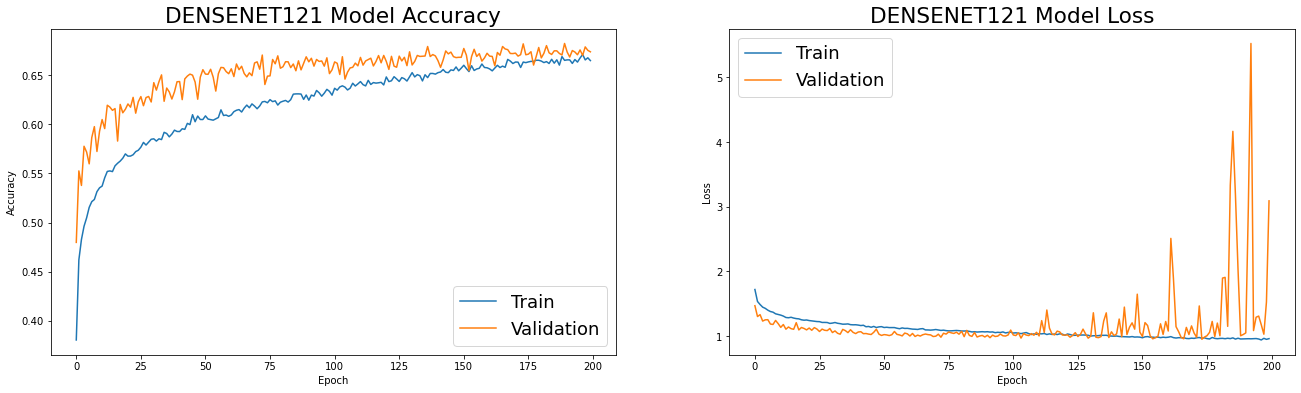

In [45]:
# Visualize accuracy and loss for DENSENET121
fig, ax = plt.subplots(1, 2, figsize = (18, 6))
fig.subplots_adjust(left = 0.02, right = 0.98, wspace = 0.2)

plt.rcParams.update({'font.size': 18})

# Plot training & validation accuracy values
ax[0].plot(densenet_model_history.history['accuracy'])
ax[0].plot(densenet_model_history.history['val_accuracy'])
ax[0].set_title('DENSENET121 Model Accuracy')
ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].legend(['Train', 'Validation'])

# Plot training & validation loss values
ax[1].plot(densenet_model_history.history['loss'])
ax[1].plot(densenet_model_history.history['val_loss'])
ax[1].set_title('DENSENET121 Model Loss')
ax[1].set_ylabel('Loss')
ax[1].set_xlabel('Epoch')
ax[1].legend(['Train', 'Validation'])

plt.show()

In [46]:
# Confusion matrix for DENSENET121
y_test_DENSENET121_target = np.array([x.argmax() for x in y_test])
DENSENET121_cm = confusion_matrix(y_test_DENSENET121_target, densenet_predictions)
print_cm(DENSENET121_cm)

   |   0   1   2   3   4   5   6   7   8   9 
---------------------------------------------
  0| 730  23  41   3   9   2  13  31 114  34 
  1|  16 785   3   6   2   2   7  13  47 119 
  2|  66   9 618  32  71  38  61  69  26  10 
  3|  25  41  97 420  39 121  79  87  46  45 
  4|  27  11  76  35 518  36  88 167  23  19 
  5|  24  27  53 114  22 544  56 110  25  25 
  6|  13  20  72  38  35  31 742  25  19   5 
  7|  26  18  16  10  29  33  13 804  20  31 
  8|  57  28   8   6   7   2   4   4 845  39 
  9|  34 140   5   7   3   7   5  25  41 733 


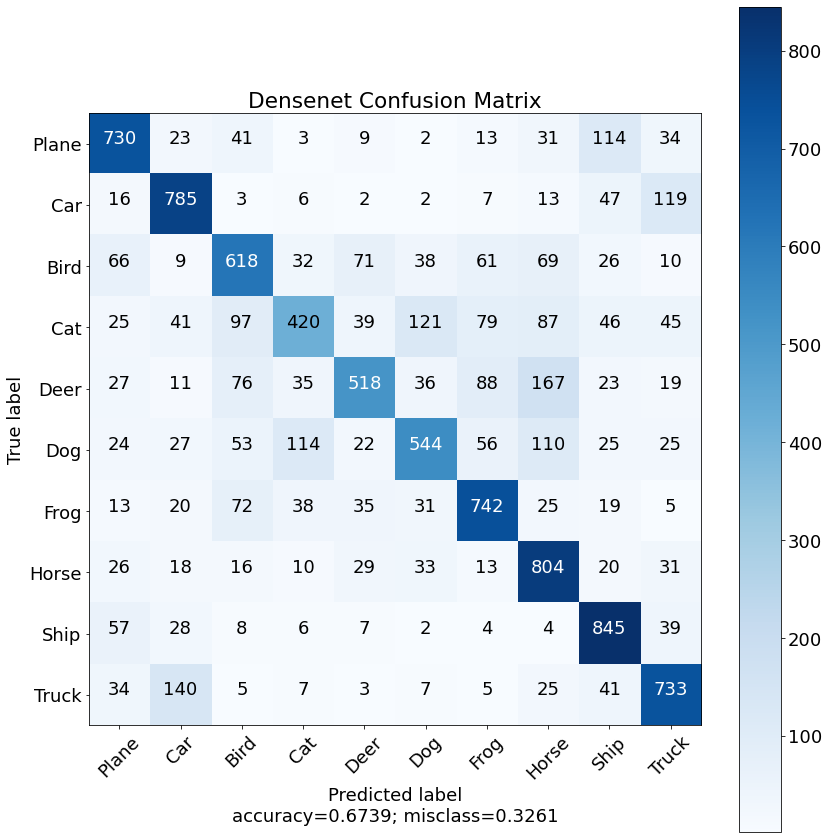

In [47]:
# Heatmap for DENSENET121
plot_confusion_matrix(DENSENET121_cm,
                          target_names = labels,
                          title='Densenet Confusion Matrix',
                          cmap="Blues",
                          normalize=False)

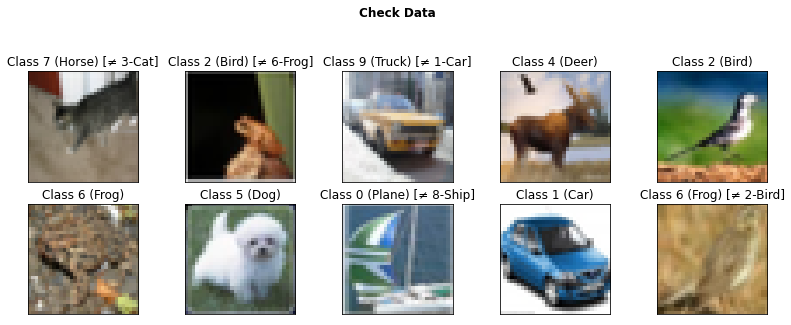

In [48]:
# Check 10 test data predictions on DENSENET121 model
check_ten(X_test, densenet_predictions, y_test, compare = True)

## CNN

In [49]:
# Instentiate CNN model
model = Sequential()


model.add(Conv2D(32, kernel_size = 3, activation = 'relu', padding = 'same', input_shape = (32, 32, 3)))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(Conv2D(64, kernel_size = 3, activation = 'relu', padding = 'same'))
model.add(MaxPool2D(pool_size = (2, 2)))
model.add(Dropout(0.2))
model.add(BatchNormalization())

model.add(Conv2D(64, kernel_size = 3, activation = 'relu', padding = 'same'))
model.add(MaxPool2D(pool_size = (2, 2)))
model.add(Dropout(0.2))
model.add(BatchNormalization())

model.add(Conv2D(128, kernel_size = 3, activation = 'relu', padding = 'same'))
model.add(MaxPool2D(pool_size = (2, 2)))
model.add(Dropout(0.2))
model.add(BatchNormalization())

model.add(Flatten())
model.add(Dropout(0.2))

model.add(Dense(256, kernel_constraint = maxnorm(3), activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())

model.add(Dense(128, kernel_constraint = maxnorm(3), activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())

# Output 
model.add(Dense(class_num, activation = 'softmax'))


In [50]:
# CNN model summary
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
dropout_3 (Dropout)          (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 64)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 16, 16, 64)        0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 16, 16, 64)       

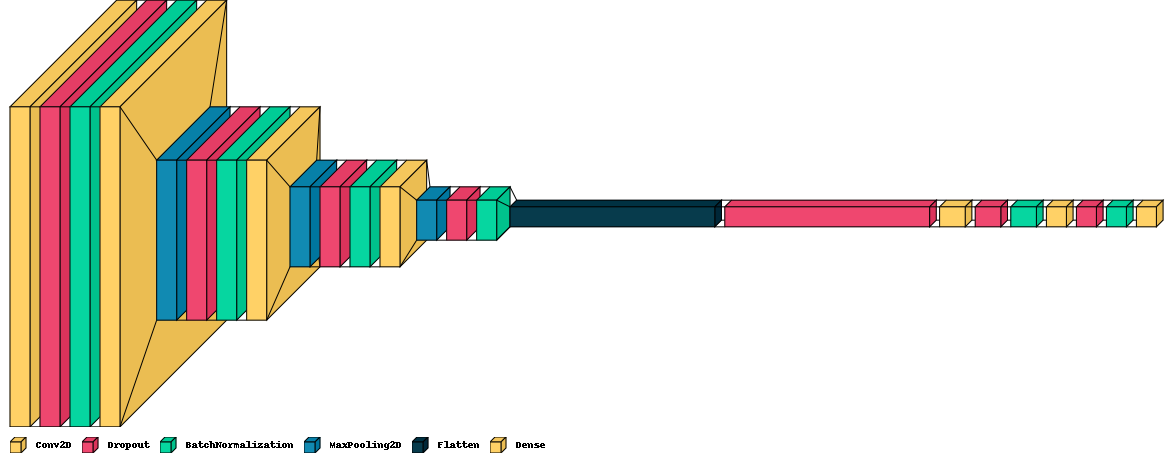

In [51]:
# Visualizing our model 
visualkeras.layered_view(model, scale_xy=10, legend=True)

In [52]:
%%time

# Compile the model
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

# Train the model
history = model.fit(train_generator, validation_data=(X_test, y_test), epochs=200, batch_size = 100, steps_per_epoch = 1000)

Epoch 1/200
1000/1000 [==============================] - 395s 391ms/step - loss: 1.9760 - accuracy: 0.2934 - val_loss: 1.5657 - val_accuracy: 0.4139
Epoch 2/200
1000/1000 [==============================] - 317s 317ms/step - loss: 1.6847 - accuracy: 0.3881 - val_loss: 1.2985 - val_accuracy: 0.5214
Epoch 3/200
1000/1000 [==============================] - 93s 93ms/step - loss: 1.5673 - accuracy: 0.4348 - val_loss: 1.2892 - val_accuracy: 0.5183
Epoch 4/200
1000/1000 [==============================] - 75s 75ms/step - loss: 1.4942 - accuracy: 0.4605 - val_loss: 1.1965 - val_accuracy: 0.5525
Epoch 5/200
1000/1000 [==============================] - 92s 92ms/step - loss: 1.4312 - accuracy: 0.4862 - val_loss: 1.1033 - val_accuracy: 0.6005
Epoch 6/200
1000/1000 [==============================] - 75s 75ms/step - loss: 1.3891 - accuracy: 0.5030 - val_loss: 1.1014 - val_accuracy: 0.6042
Epoch 7/200
1000/1000 [==============================] - 94s 93ms/step - loss: 1.3472 - accuracy: 0.5181 - val_los

In [53]:
# Evaluating the model on test data
CNN_score = model.evaluate(X_test, y_test, batch_size = 10)
print('\nTest loss: %.6f, Test accuracy: %.6f' % tuple(CNN_score))

1000/1000 [==============================] - 9s 9ms/step - loss: 0.6172 - accuracy: 0.7906

Test loss: 0.617225, Test accuracy: 0.790600


In [54]:
# Saving the model to be able to use later
import h5py
model.save('CNN_model')
print('Saved model to disk')

# Save model
CNN_model_json = model.to_json()
with open('CNN_model.json', 'w') as json_file:
     json_file.write(CNN_model_json)
# Save weights
model.save_weights('CNN_model.h5')
print("Saved model to disk")

INFO:tensorflow:Assets written to: CNN_model\assets
Saved model to disk
Saved model to disk


In [55]:
%%time

# CNN predictions on test data
predictions = np.argmax(model.predict(X_test),axis=1)

CPU times: total: 35.4 s
Wall time: 5.04 s


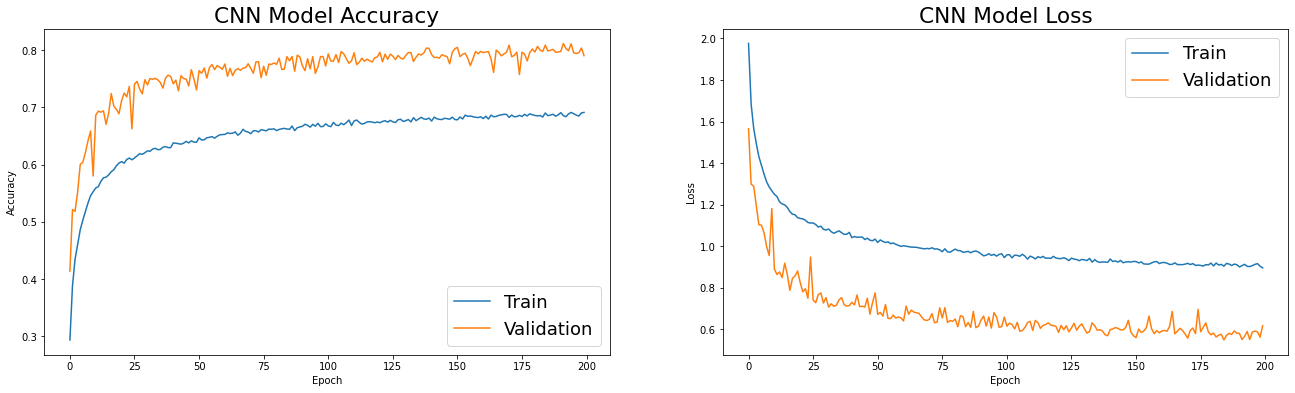

In [56]:
# Visualize accuracy and loss for CNN
fig, ax = plt.subplots(1, 2, figsize = (18, 6))
fig.subplots_adjust(left = 0.02, right = 0.98, wspace = 0.2)

plt.rcParams.update({'font.size': 18})

# Plot training & validation accuracy values
ax[0].plot(history.history['accuracy'])
ax[0].plot(history.history['val_accuracy'])
ax[0].set_title('CNN Model Accuracy')
ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].legend(['Train', 'Validation'])

# Plot training & validation loss values
ax[1].plot(history.history['loss'])
ax[1].plot(history.history['val_loss'])
ax[1].set_title('CNN Model Loss')
ax[1].set_ylabel('Loss')
ax[1].set_xlabel('Epoch')
ax[1].legend(['Train', 'Validation'])

plt.show()

In [57]:
# Confusion matrix for CNN model
y_test_target = np.array([x.argmax() for x in y_test])
cm = confusion_matrix(y_test_target, predictions)
print_cm(cm)

   |   0   1   2   3   4   5   6   7   8   9 
---------------------------------------------
  0| 820  27  13   7   2   0   3   8  67  53 
  1|   2 935   0   1   1   1   3   0   8  49 
  2|  71   8 707  41  44  13  51  32  16  17 
  3|  21  12  55 636  29  62  68  37  33  47 
  4|  34   1  66  56 682  11  69  55  15  11 
  5|  10   6  49 152  29 637  30  47  13  27 
  6|   8   6  39  28  18   4 862   3  15  17 
  7|  27   3  16  25  31  11  14 837  10  26 
  8|  50  17   3   3   1   0   5   3 897  21 
  9|  12  74   2   2   0   1   4   0  12 893 


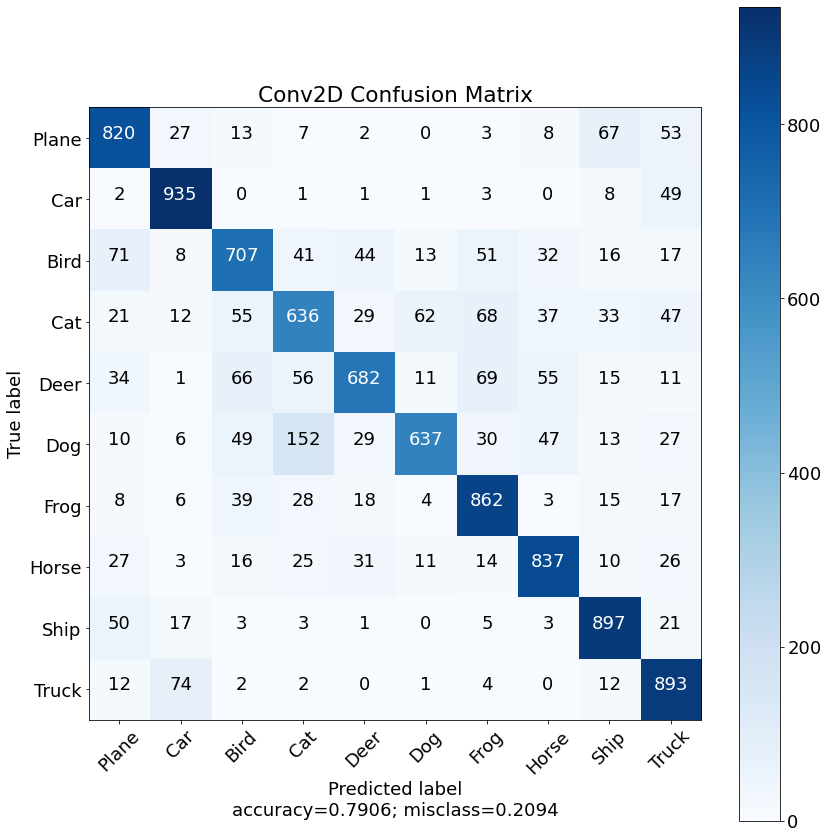

In [58]:
# Heatmap for CNN model
plot_confusion_matrix(cm,
                          target_names = labels,
                          title='Conv2D Confusion Matrix',
                          cmap="Blues",
                          normalize=False)

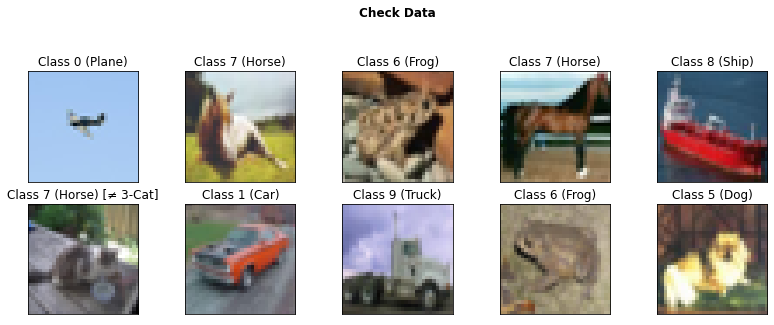

In [59]:
# Check 10 test data predictions on CNN model
check_ten(X_test, predictions, y_test, compare = True)